<a href="https://colab.research.google.com/github/ANadalCardenas/attention/blob/main/ACV_01_video_LAB_TODO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Neural Architectures for Video Encoding: Human Action Recognition (HAR)**
======
*Notebook created in PyTorch by [Josep López](https://www.linkedin.com/in/yusepp/) for the [UPC School](https://www.talent.upc.edu/ing/) (2024)*

In this notebook, you will implement and train the R(2+1)D network, a ResNet-based architecture for video processing.<br>
This model decomposes 3D convolutions into spatial (2D) and temporal (1D) components for effective feature extraction.<br>
You will apply it to the UCF101 dataset, containing 13,320 video clips across 101 human action classes.<br>

# Lab Tasks

## Core Tasks

### 1. Data Pipeline
- Developing a Video Dataset capable of handling UCF101 videos
- Implementing an efficient DataLoader with appropriate clip generation
- Handling video frame sampling and preprocessing

### 2. Model Implementation
- Implementing the R(2+1)D CNN architecture using PyTorch
- Ensuring correct implementation of spatial and temporal convolutions
- Proper residual connections and model configuration

### 3. Metrics Implementation
- Accuracy implementation
- F1-Score implementation

### 3. Training and Optimization
- Training the network with proper hyperparameter settings
- Managing the training loop and optimization process

### 4. Evaluation and Analysis
- Evaluating and comparing model performance against pretrained state-of-the-art models
- Analyzing feature spaces through t-SNE visualization
- Analyzing and visualizing misclassified examples

## Optional Task

### Extra task
- Fine-tuning a pretrained video model on UCF101.
- Comparing performance against the base implementation.
- Explore feature space.

<br><br>
`Notes:`<br>
`1. For guidance on PyTorch functions, consult the` [PyTorch documentation](https://pytorch.org/docs/stable/index.html)`.` <br>
`2. Remember to enable GPU acceleration in` ```Runtime > Change runtime type > Hardware Accelerator```

### **UCF101 Dataset**

The UCF101 is a video action recognition dataset containing 13,320 clips from YouTube across 101 human action classes.<br>
All videos capture real-world scenarios, making it ideal for developing and testing action recognition models.

Key features of the UCF101 dataset include:

- **Action Categories**: The dataset covers five main types of actions: Human-Object Interaction,<br>
Body-Motion Only, Human-Human Interaction, Musical Instruments, and Sports.

- **Video Format**: RGB video clips at 25 FPS (320x240 pixels).

- **Dataset Split**: We'll use 4,397 videos (33% of the full dataset), maintaining balanced <br>
distribution across all classes.

- **Challenging Factors**: Videos include different viewpoints, moving cameras, varied lighting, <br>
 and cluttered backgrounds.

`Note: To address Colab's computational limitations, we will use a 33% subset of the UCF101 dataset`

![Action Recognition Example](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*EvxO1sdZ1DCLfDxQNTiflQ.png)

Install libraries here

In [1]:
%%capture
!pip install kagglehub tqdm einops mediapy -qqq --quiet
!pip install git+https://github.com/facebookresearch/pytorchvideo.git

Import libraries here

In [2]:
# Standard library imports
import glob
import os
from abc import ABC, abstractmethod
from collections import defaultdict
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple, Union

# Third-party data science libraries
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import mediapy as mp

# Image and video processing
import cv2
from einops import rearrange
from tqdm import tqdm

# PyTorch core
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.amp import GradScaler, autocast
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import DataLoader, Dataset

# PyTorch Vision
from torchvision.models.video import r2plus1d_18, swin3d_b
from torchvision.transforms.v2 import (
    Compose,
    Resize,
    ToDtype,
    ToImage
)

# PyTorch Video
from pytorchvideo.transforms import AugMix

# External data and models
import kagglehub

Download Dataset and Pretrained Weights

In [3]:
%%capture
# Execution Time @1 Min.
# Download and Extract HMDB51 dataset
if not os.path.exists("./ucf101_subset"):
    path = kagglehub.dataset_download("yusepp/ucf101-subset")
    !mkdir -p ./ucf101_subset
    !mv {path}/* ./ucf101_subset
    print("Dataset downloaded and extracted successfully! (./ucf101_subset)")

if not os.path.exists('r2plus1d_18_DEFAULT_finetuned_10_epochs.pth'):
    path = kagglehub.model_download("yusepp/aidl_video_lab/pyTorch/default")
    !mv {path}/* ./

Extracting files...


### **Exercise 1: Define a Video Dataset and Video DataLoader**

Working with video data introduces unique challenges compared to image processing. While images require simple loading of individual frames and labels, video processing demands:

- Temporal sampling and clip generation
- Memory-efficient frame loading
- Frame sequence handling
- Temporal stride management

**Your Tasks:**
1. Implement the `UCF101Dataset` class
   - Design efficient video loading mechanisms
   - Handle temporal sampling and clip generation
   - Implement frame preprocessing
   - Frame Resolution: 112×112 pixels (width × height)
   - Sequence Length: 8 frames per video clip
   - Input Format: CTHW (Channels, Time, Height, Width)
2. Create the DataLoader pipeline
   - Set up batch processing and worker management
   - Handle memory optimization

**Implementation Note:**
While you can use any video reading library, I recommend starting with cv2 (OpenCV).

In [4]:
class UCF101Dataset(Dataset):
    """A PyTorch Dataset for loading and preprocessing UCF101 video data.

    Attributes:
        files (List[str]): List of paths to video files
        labels (np.ndarray): Array of numerical labels corresponding to video classes
        sequence_length (int): Number of frames to sample from each video
        transforms (Optional[callable]): Optional transforms to apply to the frames
    """

    def __init__(self, data_path: str, sequence_length: int, transforms: Optional[callable] = None) -> None:
        """Initialize the UCF101 dataset."""
        super().__init__()

        # TODO: Find all .avi files in data_path and sort them
        self.files = sorted(glob.glob(os.path.join(data_path, "*", "*.avi")))

        # TODO: Convert folder names to numerical labels (hint: use np.unique)
        self.activities = np.unique([os.path.basename(os.path.dirname(f)) for f in self.files])
        self.labels, _ = pd.factorize([os.path.basename(os.path.dirname(f)) for f in self.files])

        self.sequence_length = sequence_length
        self.transforms = transforms

    def __len__(self) -> int:
        return len(self.files)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        return self.read_video(self.files[idx]), self.labels[idx]

    def read_video(self, video_path: str) -> torch.Tensor:
        """Read and preprocess a video file.

        Returns:
            torch.Tensor: Preprocessed video frames of shape (C, T, H, W)
        """
        # TODO: Open video and get total frame count
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # TODO: Calculate sampling indices for uniform frame selection
        if total_frames < self.sequence_length:
            indices = np.arange(total_frames)
        else:
            indices = np.linspace(0, total_frames - 1, self.sequence_length, dtype=int)

        frames = []
        frame_idx = 0

        while cap.isOpened() and len(frames) < self.sequence_length:
            # TODO: Read and process frames (consider color space and normalization)
            ret, frame = cap.read()
            if not ret:
                break

            if frame_idx in indices:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = torch.from_numpy(frame).permute(2, 0, 1) # HWC -> CHW
                frames.append(frame)

            frame_idx += 1

        cap.release()

        # TODO: Handle case when video is shorter than sequence_length
        if len(frames) < self.sequence_length:
            last_frame = frames[-1] if frames else torch.zeros(3, 112, 112, dtype=torch.uint8) # Default if no frames
            while len(frames) < self.sequence_length:
                frames.append(last_frame)

        # TODO: Convert frames to tensor with shape (C, T, H, W)
        frames = torch.stack(frames, dim=1) # List of CHW -> CTHW

        if self.transforms:
            frames = self.transforms(frames)

        return frames


def get_loader(split: str, transforms: callable, shuffle: bool = False,
               batch_size: int = 32, sequence_length: int = 8) -> DataLoader:
    """Create a DataLoader for the specified dataset split."""
    # TODO: Create and return DataLoader with appropriate parameters
    data_path = f"./ucf101_subset/{split}" # Adjust based on your dataset structure
    dataset = UCF101Dataset(data_path, sequence_length, transforms)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2, pin_memory=True)

In [5]:
def visualize_video_batch(batch_videos: torch.Tensor, batch_labels: torch.Tensor,
                         activities: List[str] = None, num_videos: int = 4):
    """Display first 4 videos from a batch in a 1x4 grid."""
    videos = batch_videos[:num_videos].cpu().numpy()
    labels = batch_labels[:num_videos].cpu().numpy()

    videos_dict = {
        f"Video {i+1}{f'\nClass: {activities[label]}' if activities is not None else ''}":
        rearrange(((video - video.min()) / (video.max() - video.min()) * 255).astype(np.uint8),
                 "c t h w -> t h w c")
        for i, (video, label) in enumerate(zip(videos, labels))
    }

    mp.show_videos(videos_dict, width=320, height=240, fps=4, columns=4, border=True)

In [6]:
# Sample basic transforms for video preprocessing
transforms = [
   ToImage(),
   ToDtype(torch.float32, scale=True),
   Resize((112, 112))
]

# TODO: Create dataloader for validation split
loader = get_loader(split='val', transforms=Compose(transforms),
                    shuffle=True, batch_size=32, sequence_length=8)

# TODO: Visualize first batch using dataset.activities for class names
for videos, labels in loader:
   visualize_video_batch(videos, labels, activities=loader.dataset.activities)
   break

/tmp/ipython-input-567568348.py:20: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  self.labels, _ = pd.factorize([os.path.basename(os.path.dirname(f)) for f in self.files])


### **Overview of the R(2+1)D Network**

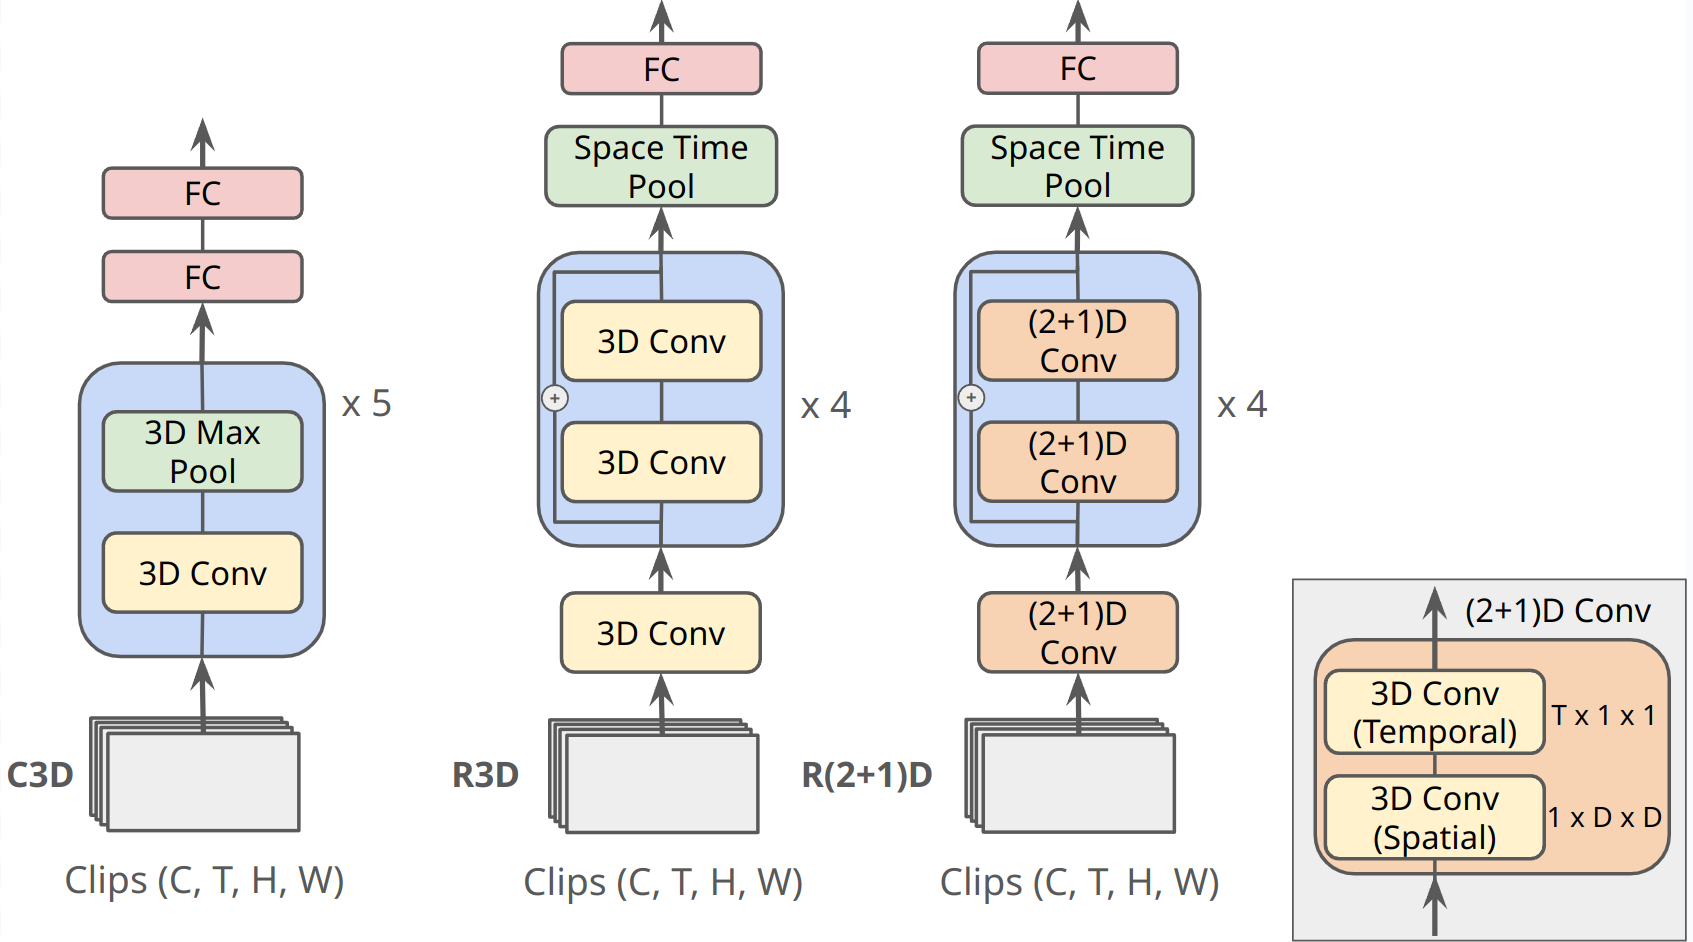

*Comparing C3D, R3D (3D nets) vs R(2+1)D*

The R(2+1)D network enhances video understanding by improving traditional 3D CNNs. It decomposes 3D convolutions into two simpler operations:  

1. **2D Spatial Convolution**: Extracts spatial features (height and width) within each frame.  
2. **1D Temporal Convolution**: Captures motion dynamics across frames (time).

This **decomposition** introduces non-linearity between spatial and temporal processing, improving learning efficiency. **Residual connections** further enhance the model by allowing shortcut paths, enabling stable training and effective feature propagation even in deeper networks.  

The network follows a **ResNet-inspired architecture**, organizing layers into blocks to capture spatial and temporal features hierarchically. It processes video tensors of shape `(batch_size, channels, sequence_size, height, width)` and outputs action class predictions, making it efficient and powerful for video recognition tasks.

**Implementation Note:**
For detailed specifications, refer to the [original paper](https://arxiv.org/pdf/1711.11248).

In [7]:
class R2Plus1DConv(nn.Module):
    """R(2+1)D convolution block that decomposes 3D conv into spatial and temporal operations.

    The key idea is to split a 3D convolution into separate spatial (2D) and temporal (1D)
    convolutions. This creates a bottleneck architecture where:
    - First, we perform spatial convolution (height and width)
    - Then, we process temporal information

    The number of middle channels is calculated to maintain roughly the same number of
    parameters as a standard 3D convolution while potentially improving performance through
    the decomposition of operations.
    """
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int = 3,
                 stride: int = 1, padding: int = 1):
        super().__init__()
        kernel_size = (kernel_size, kernel_size, kernel_size)

        # TODO: Calculate middle channels for the bottleneck
        # The formula balances parameters between spatial and temporal convolutions
        # For a standard 3D conv: params = (k_t * k_h * k_w * c_in * c_out)
        # For R(2+1)D: params = (k_h * k_w * c_in * c_mid) + (k_t * c_mid * c_out)
        # Solve c_mid
        # Based on torchvision's Conv2Plus1D implementation
        mid_channels = (in_channels * out_channels * kernel_size[0] * kernel_size[1] * kernel_size[2]) // \
            (in_channels * kernel_size[1] * kernel_size[2] + kernel_size[0] * out_channels)

        # TODO: Implement spatial convolution (2D)
        self.spatial = nn.Sequential(
            nn.Conv3d(
                in_channels=in_channels,
                out_channels=mid_channels,
                kernel_size=(1, kernel_size[1], kernel_size[2]),
                stride=(1, stride, stride),
                padding=(0, padding, padding),
                bias=False
            ),
            nn.BatchNorm3d(mid_channels),
            nn.ReLU(inplace=True)
        )

        # TODO: Implement temporal convolution (1D)
        # Hint: Use Conv3d with spatial kernel_size=1
        self.temporal = nn.Sequential(
            nn.Conv3d(
                in_channels=mid_channels,
                out_channels=out_channels,
                kernel_size=(kernel_size[0], 1, 1),
                stride=(stride, 1, 1),
                padding=(padding, 0, 0),
                bias=False
            ),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: Implement forward pass through spatial and temporal convolutions
        x = self.spatial(x)
        x = self.temporal(x)
        return x


class ResBlock(nn.Module):
    """Residual block composed of two R(2+1)D convolutions and a shortcut connection."""
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1):
        super().__init__()
        # Main convolution path
        self.conv_path = nn.Sequential(
            R2Plus1DConv(in_channels, out_channels, stride=stride),
            R2Plus1DConv(out_channels, out_channels)
        )

        # Shortcut path (1x1x1 conv if dimensions change, otherwise identity)
        self.shortcut = R2Plus1DConv(in_channels, out_channels, kernel_size=1, stride=stride, padding=0) \
            if stride != 1 or in_channels != out_channels else nn.Identity()

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: Implement residual connection
        shortcut_out = self.shortcut(x)
        conv_path_out = self.conv_path(x)
        return self.relu(shortcut_out + conv_path_out)


class R2Plus1DResNet(nn.Module):
    """R(2+1)D ResNet architecture for video classification.

    Args:
        blocks: List of number of blocks in each stage (e.g., [2,2,2,2] for R2Plus1D-18)
        num_classes: Number of output classes
    """
    def __init__(self, blocks: List[int], num_classes: int = 101):
        super().__init__()

        # Initial convolution and pooling
        self.stem = R2Plus1DConv(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))

        # Residual stages
        self.body = nn.Sequential(
            self._stack_residual_blocks(64, 64, blocks[0], 1),     # Stage 1: 64 → 64
            self._stack_residual_blocks(64, 128, blocks[1], 2),    # Stage 2: 64 → 128
            self._stack_residual_blocks(128, 256, blocks[2], 2),   # Stage 3: 128 → 256
            self._stack_residual_blocks(256, 512, blocks[3], 2)    # Stage 4: 256 → 512
        )

        # Classification head
        self.avgpool = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.head = nn.Linear(512, num_classes)

        self._init_weights()

    def _stack_residual_blocks(self, in_channels: int, out_channels: int,
                             num_blocks: int, stride: int) -> nn.Sequential:
        """Helper method to create a stack of residual blocks."""
        return nn.Sequential(
            ResBlock(in_channels, out_channels, stride),  # First block with stride
            *[ResBlock(out_channels, out_channels) for _ in range(num_blocks - 1)]  # Rest with stride 1
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: Implement full forward pass
        # 1. Apply stem convolution and pooling
        x = self.stem(x)
        x = self.maxpool(x)

        # 2. Pass through residual body
        x = self.body(x)

        # 3. Apply global average pooling and classification head
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Flatten (B, C, 1, 1, 1) to (B, C)
        x = self.head(x)
        return x

    def _init_weights(self):
        """Initialize model weights using Kaiming initialization."""
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                nn.init.zeros_(m.bias)

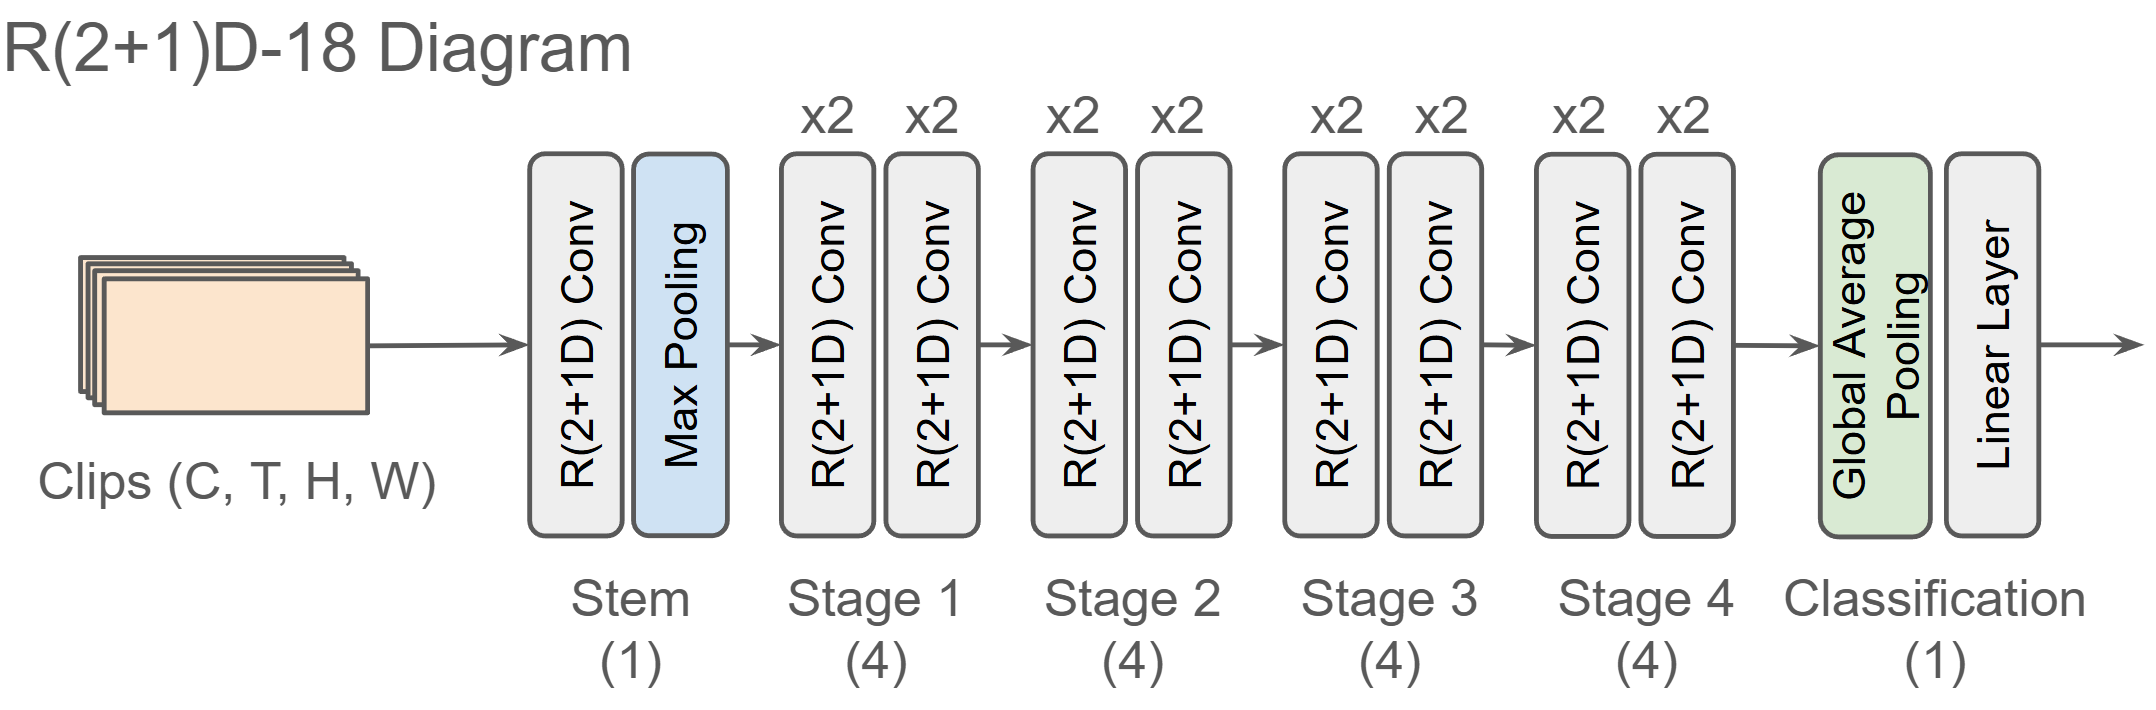

In [8]:
def create_r2plus1d_18(num_classes: int = 101) -> R2Plus1DResNet:
    """Create a 18-layer R(2+1)D ResNet."""
    return R2Plus1DResNet([2, 2, 2, 2], num_classes)

def create_r2plus1d_10(num_classes: int = 101) -> R2Plus1DResNet:
    """Create a 10-layer R(2+1)D ResNet."""
    return R2Plus1DResNet([1, 1, 1, 1], num_classes)

### **Define Metrics**

Implement 2 evaluation metrics:

**Accuracy**
* Implement the `Accuracy` class handling top-k predictions (k=1,5)

**F1-Score**
* Create `F1Score` class for multi-class scenario

**Mathematical Formulas:**
$$\text{Accuracy} = \frac{\text{Correct Predictions}}{\text{Total Predictions}}, \quad \text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}\quad$$
   
where: $$\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}, \quad \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$

**Implementation Details:**
- Use vectorized operations as much as possible for optimal implementation
- Implement metrics using classes that inherit from the abstract class `Metric` with methods:
  - `update(logits, targets)`: Updates metric state with new predictions
  - `compute()`: Returns current metric value
  - `reset()`: Resets metric state

In [9]:
class Accuracy():
    def __init__(self, name: str, top_k: int = 1) -> None:
        """Initialize top-k accuracy metric."""
        # TODO: Initialize accuracy tracking variables and parameters
        self.name = name
        self.top_k = top_k
        self.correct = 0
        self.total = 0

    def update(self, logits: torch.Tensor, targets: torch.Tensor) -> None:
        """Update accuracy computation with new predictions.

        Args:
            logits: Model outputs (before softmax) with shape (batch_size, num_classes)
            targets: Ground truth labels with shape (batch_size,)
        """
        # TODO: Compute top-k predictions and count correct ones
        # Step 1: Get top k predicted class indices using torch.topk
        _, topk_preds = logits.topk(self.top_k, dim=1, largest=True, sorted=True)

        # TODO: Compare predictions with targets
        # Step 2: Expand targets for comparison with top-k predictions
        targets_expanded = targets.view(-1, 1).expand_as(topk_preds)

        # Step 3: Count correct predictions
        correct = (topk_preds == targets_expanded).sum().item()

        # Step 4: Update tracking variables
        self.correct += correct
        self.total += targets.size(0)

    def compute(self) -> float:
        """Compute top-k accuracy score."""
        # TODO: Return accuracy (handle division by zero)
        return self.correct / self.total if self.total > 0 else 0.0

    def reset(self) -> None:
        """Reset accuracy computation."""
        # TODO: Reset tracking variables to initial values
        self.correct = 0
        self.total = 0

class F1Score():
    def __init__(self, num_classes: int, name: str) -> None:
        """Initialize F1 score metric."""
        # TODO: Initialize metric parameters and tracking variables
        self.name = name
        self.num_classes = num_classes
        # Initialize tensors for TP, FP, FN
        self.tp = torch.zeros(num_classes)
        self.fp = torch.zeros(num_classes)
        self.fn = torch.zeros(num_classes)

    def update(self, logits: torch.Tensor, targets: torch.Tensor) -> None:
        """Update F1 score computation with new predictions.

        Args:
            logits: Model outputs (before softmax) with shape (batch_size, num_classes)
            targets: Ground truth labels with shape (batch_size,)
        """
        # TODO: Convert logits to predictions
        preds = torch.argmax(logits, dim=1)

        # TODO: Create one-hot encodings
        preds_one_hot = F.one_hot(preds, num_classes=self.num_classes)
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes)

        # TODO: Update TP, FP, FN using vectorized boolean operations
        # (avoid using for loop)
        self.tp += (preds_one_hot * targets_one_hot).sum(dim=0).cpu()  # True positives
        self.fp += (preds_one_hot * (1 - targets_one_hot)).sum(dim=0).cpu()  # False positives
        self.fn += ((1 - preds_one_hot) * targets_one_hot).sum(dim=0).cpu()  # False negatives

    def compute(self) -> float:
        """Compute macro F1 score."""
        # TODO: Compute precision and recall
        precision = self.tp / (self.tp + self.fp + 1e-6)
        recall = self.tp / (self.tp + self.fn + 1e-6)

        # TODO: Compute F1 score
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

        # TODO: Return macro F1 (mean across classes)
        return torch.mean(f1).item()

    def reset(self) -> None:
        """Reset F1 score computation."""
        # TODO: Reset TP, FP, FN tensors to zero
        self.tp = torch.zeros(self.num_classes)
        self.fp = torch.zeros(self.num_classes)
        self.fn = torch.zeros(self.num_classes)

In [10]:
class F1Score():
    def __init__(self, num_classes: int, name: str) -> None:
        """Initialize F1 score metric."""
        # TODO: Initialize metric parameters and tracking variables
        self.name = name
        self.num_classes = num_classes
        # Initialize tensors for TP, FP, FN
        self.tp = torch.zeros(num_classes)
        self.fp = torch.zeros(num_classes)
        self.fn = torch.zeros(num_classes)

    def update(self, logits: torch.Tensor, targets: torch.Tensor) -> None:
        """Update F1 score computation with new predictions.

        Args:
            logits: Model outputs (before softmax) with shape (batch_size, num_classes)
            targets: Ground truth labels with shape (batch_size,)
        """
        # TODO: Convert logits to predictions
        preds = torch.argmax(logits, dim=1)

        # TODO: Create one-hot encodings
        preds_one_hot = F.one_hot(preds, num_classes=self.num_classes)
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes)

        # TODO: Update TP, FP, FN using vectorized boolean operations
        # (avoid using for loop)
        self.tp += (preds_one_hot * targets_one_hot).sum(dim=0).cpu()  # True positives
        self.fp += (preds_one_hot * (1 - targets_one_hot)).sum(dim=0).cpu()  # False positives
        self.fn += ((1 - preds_one_hot) * targets_one_hot).sum(dim=0).cpu()  # False negatives

    def compute(self) -> float:
        """Compute macro F1 score."""
        # TODO: Compute precision and recall
        precision = self.tp / (self.tp + self.fp + 1e-6)
        recall = self.tp / (self.tp + self.fn + 1e-6)

        # TODO: Compute F1 score
        f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

        # TODO: Return macro F1 (mean across classes)
        return torch.mean(f1).item()

    def reset(self) -> None:
        """Reset F1 score computation."""
        # TODO: Reset TP, FP, FN tensors to zero
        self.tp = torch.zeros(self.num_classes)
        self.fp = torch.zeros(self.num_classes)
        self.fn = torch.zeros(self.num_classes)

### **Training Pipeline and Optimization**

Training deep video models requires careful management of resources and optimization strategies. The `Trainer` class handles the complete training lifecycle.

**Your Tasks:**

- `train()`: Main training loop managing epochs and metrics
- `train_epoch()`: Single epoch training with optimization. Uses `tqdm` to track per-batch progress and display live metrics
- `validate()`: Model evaluation on validation set
- `test()`: Final evaluation on test set after training
- `forward_pass()`: Process single batch with mixed precision
- `backward_pass()`: Execute backward pass with gradient scaling and clipping
- `compute_metrics()`: Compute and reset all metrics
- `save_checkpoint()`: Save model states and metrics
- `load_checkpoint()`: Load existing checkpoint
- `log_epoch()`: Display formatted training/validation metrics after each epoch
- `print_params()`: Print parameter counts in a concise and elegant manner
- `plot_history()`: Generate training history plots for loss and metrics

**Implementation Details:**  
- Mixed precision (FP16) training is highly recommended for:
  - Fitting larger batches in GPU memory
  - 2-3x training speed improvement
  - More efficient inference
- The trainer handles:
  - Automatic mixed precision via `torch.amp`
  - Proper gradient scaling with `GradScaler`
  - Early stopping and model selection
  - Progress tracking with `tqdm` for live updates
  - Metric logging per epoch
  - Checkpointing for saving and loading model states
  - Visualization of training history using `seaborn` and `matplotlib`


In [11]:
class Trainer():
    def __init__(
        self,
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        test_loader: Optional[DataLoader] = None,
        optimizer: Optimizer = None,
        criterion: nn.Module = nn.CrossEntropyLoss(),
        metrics: List = None,
        device: str = "cuda" if torch.cuda.is_available() else "cpu",
        config: Dict = None
    ):
        # Initialize model and move to device
        self.device = torch.device(device)
        self.model = model.to(self.device)

        # Initialize data loaders
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader

        # Initialize training components
        self.optimizer = optimizer
        self.criterion = criterion
        self.metrics = metrics or []

        # TODO: Setup training configuration
        self.config = config or {}
        self.epochs = self.config.get('epochs', 100)

        # TODO: Initialize mixed precision scaler and history tracking
        # Hint: GradScaler should be enabled based on config['mixed_precision']
        self.scaler = GradScaler(enabled=self.config.get('mixed_precision', False))
        self.history = {'train': [], 'val': [], 'test': []}

        # TODO: Setup checkpoint directory
        self.checkpoint_dir = Path(self.config.get('checkpoint_dir', 'checkpoints'))
        self.checkpoint_dir.mkdir(parents=True, exist_ok=True)  # Create directory

        self.print_params()

    def forward_pass(self, batch: Tuple[Tensor, Tensor]) -> Tuple[Tensor, Tensor, Tensor]:
        """Perform forward pass with mixed precision support"""
        # Move batch to device
        x, y = batch
        x, y = x.to(self.device), y.to(self.device)

        # TODO: Implement forward pass with mixed precision
        with autocast(device_type=self.device.type, enabled=self.scaler.is_enabled()):
            outputs = self.model(x)
            loss = self.criterion(outputs, y)

        return outputs, y, loss

    def backward_pass(self, loss: Tensor) -> None:
        """Execute backward pass with gradient scaling and clipping"""
        # TODO: Scale loss and compute gradients
        self.scaler.scale(loss).backward()

        # TODO: Optional gradient clipping
        if self.config.get('max_norm'):
            self.scaler.unscale_(self.optimizer)
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.get('max_norm'))

        # TODO: Optimizer and scaler step
        self.scaler.step(self.optimizer)
        self.scaler.update()
        self.optimizer.zero_grad()

    def compute_metrics(self, preds: Tensor, targets: Tensor, step: bool) -> Dict[str, float]:
        """Compute all metrics and optionally reset them
        Args:
            preds: Model predictions
            targets: Ground truth labels
            step: If True, only update metrics; if False, compute and reset
        """
        metrics_results = {}
        for metric in self.metrics:
            # TODO: Update metrics and optionally compute/reset
            metric.update(preds.cpu(), targets.cpu())
            metrics_results[metric.name] = metric.compute() if not step else None # Only compute if not step
            if not step:
                metric.reset()
        # Filter out None values if step is True
        return {k: v for k, v in metrics_results.items() if v is not None}

    def train_epoch(self) -> Dict[str, float]:
        """Complete one training epoch"""
        self.model.train()
        total_loss = 0.0

        pbar = tqdm(self.train_loader, desc="Training", leave=False)
        for batch_idx, batch in enumerate(pbar):
            # TODO: Implement training step
            preds, targets, loss = self.forward_pass(batch)
            self.backward_pass(loss)

            # TODO: Update metrics and progress bar
            total_loss += loss.item()
            metrics = self.compute_metrics(preds, targets, step=True)
            pbar.set_postfix({
                'loss': total_loss / (batch_idx + 1),
                **{k: f'{v:.4f}' for k,v in metrics.items()}
            })

        # Return epoch metrics
        final_metrics = self.compute_metrics(preds, targets, step=False)
        return {
            'loss': total_loss / len(self.train_loader),
            **final_metrics
        }

    def validate(self, loader: DataLoader) -> Dict[str, float]:
        """Run validation/testing pass"""
        self.model.eval()
        total_loss = 0.0

        # TODO: Implement validation loop with torch.no_grad()
        with torch.no_grad():
            pbar = tqdm(loader, desc="Validation/Testing...", leave=False)
            for batch_idx, batch in enumerate(pbar):
                preds, targets, loss = self.forward_pass(batch)
                total_loss += loss.item()
                metrics = self.compute_metrics(preds, targets, step=True)
                pbar.set_postfix({
                    'loss': total_loss / (batch_idx + 1),
                    **{k: f'{v:.4f}' for k,v in metrics.items()}
                })

        final_metrics = self.compute_metrics(preds, targets, step=False)
        return {
            'loss': total_loss / len(loader),
            **final_metrics
        }

    def test(self) -> Dict[str, float]:
        """Run final test evaluation"""
        if self.test_loader is None:
            print("Test loader not provided.")
            return {}
        return self.validate(self.test_loader)

    def log_epoch(self, epoch: int, train_metrics: Dict, val_metrics: Dict) -> None:
        """Print formatted epoch summary"""
        # TODO: Format and print epoch metrics
        header = f"Epoch {epoch+1}/{self.epochs}"
        train_str = " | ".join([f"{k}: {v:.4f}" for k, v in train_metrics.items()])  # Format train metrics
        val_str = " | ".join([f"{k}: {v:.4f}" for k, v in val_metrics.items()])    # Format val metrics
        print(f"{header}\n{'Train:':<8}{train_str}\n{'Val:':<8}{val_str}\n")

    def save_checkpoint(self, name: str) -> None:
        """Save complete training state"""
        checkpoint = {
            'model': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'scaler': self.scaler.state_dict() if self.scaler is not None else None,
            'history': self.history,
            'config': self.config
        }
        # TODO: Save checkpoint using torch.save
        torch.save(checkpoint, self.checkpoint_dir / f"{name}.pt")


    def print_params(self, trainable: bool = True) -> None:
        """Print model parameter statistics"""
        # TODO: Calculate and print parameter counts in millions
        total_params = sum(p.numel() for p in self.model.parameters()) / 1e6
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad) / 1e6

        if trainable:
            percentage = (trainable_params / total_params) * 100
            print(f"Trainable parameters: {trainable_params:.2f}M ({percentage:.2f}%) ")
        print(f"Total parameters: {total_params:.2f}M")

    def plot_history(self) -> None:
        """Generate training history plots"""
        sns.set(style="whitegrid")
        phases = [p for p in ['train', 'val', 'test'] if self.history[p]] # Only plot phases that have data
        if not phases: return # No data to plot

        # Get all metric names from the first training epoch
        metrics = list(self.history["train"][0].keys())
        num_metrics = len(metrics)

        # TODO: Create subplot for each metric
        fig, axes = plt.subplots(1, num_metrics, figsize=(5 * num_metrics, 5))
        if num_metrics == 1: axes = [axes] # Ensure axes is iterable even for a single metric

        # TODO: Plot each metric for each phase
        for i, metric in enumerate(metrics):
            ax = axes[i]
            for phase in phases:
                if phase in self.history and self.history[phase]:
                    sns.lineplot(x=range(len(self.history[phase])),
                                 y=[m[metric] for m in self.history[phase]],
                                 label=phase,
                                 ax=ax)
            ax.set_title(metric.replace('_', ' ').capitalize())
            ax.set_xlabel('Epoch')
            ax.set_ylabel('Value')
            ax.legend()

        # TODO: Save and show plots
        fig.suptitle('Training History', y=1.02) # Add a main title
        fig.tight_layout()
        fig.savefig(self.checkpoint_dir / "training_history.png")
        plt.show()
        plt.close(fig)

    def train(self) -> None:
        """Main training loop"""
        print(f"Starting training for {self.epochs} epochs")

        best_val_loss = float('inf')

        for epoch in range(self.epochs):
            # TODO: Training and validation
            train_metrics = self.train_epoch()
            val_metrics = self.validate(self.val_loader)

            # TODO: Update history and save checkpoints
            self.history['train'].append(train_metrics)
            self.history['val'].append(val_metrics)

            self.log_epoch(epoch, train_metrics, val_metrics)
            self.save_checkpoint('latest')

            # TODO: Save best model if validation loss improved
            if val_metrics['loss'] < best_val_loss:
                best_val_loss = val_metrics['loss']
                self.save_checkpoint('best')
                print(f"---> Best model saved at epoch {epoch+1} with validation loss: {best_val_loss:.4f}")

        # TODO: Final test evaluation
        if self.test_loader:
            print("\n--- Running final test evaluation ---")
            test_metrics = self.test()
            self.history['test'].append(test_metrics)
            test_str = " | ".join(f"{k}: {v:.4f}" for k, v in test_metrics.items())
            print(f"{'Test:':<8}{test_str}")

        self.plot_history()

In [12]:
# Enable for mixed precision
torch.set_float32_matmul_precision('high')

# TODO: Define transforms for training and validation
train_transforms = Compose([
    ToImage(),
    Resize((112, 112)),
    # Removed AugMix as it expects image-like tensor (C, H, W) but receives video tensor (C, T, H, W)
    ToDtype(torch.float32, scale=True)
])

val_transforms = Compose([
    ToImage(),
    Resize((112, 112)),
    ToDtype(torch.float32, scale=True)
])

# TODO: Initialize dataloaders for each split
# Remember: Different shuffle settings for train vs val/test
train_dataloader = get_loader(
   split='train',
   transforms=train_transforms,
   shuffle=True,  # Shuffle training data
   batch_size=32,  # Choose appropriate batch size
   sequence_length=8  # Set video sequence length
)

val_dataloader = get_loader(
   split='val',
   transforms=val_transforms,
   shuffle=False,  # Don't shuffle validation
   batch_size=32,
   sequence_length=8
)

test_dataloader = get_loader(
   split='test',
   transforms=val_transforms,
   shuffle=False,  # Don't shuffle test
   batch_size=32,
   sequence_length=8
)

# Get the number of classes from the dataset
num_classes = len(train_dataloader.dataset.activities)

# TODO: Initialize and compile model
model = create_r2plus1d_10(
   num_classes=num_classes  # Number of classes in your dataset
)
# model = torch.compile(model) # Remove initial compilation from trainer's model

# TODO: Initialize optimizer with appropriate hyperparameters
optimizer = torch.optim.AdamW(
   model.parameters(),
   lr=0.001  # Set learning rate
)

# TODO: Initialize loss function
criterion = nn.CrossEntropyLoss()

# TODO: Initialize metrics for model evaluation
metrics = [
   Accuracy(name="top_1_acc", top_k=1),  # Top-1 accuracy
   Accuracy(name="top_5_acc", top_k=5),  # Top-5 accuracy
   F1Score(
       name="f1",
       num_classes=num_classes  # Same as model num_classes
   )
]

/tmp/ipython-input-567568348.py:20: FutureWarning: factorize with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  self.labels, _ = pd.factorize([os.path.basename(os.path.dirname(f)) for f in self.files])


Trainable parameters: 14.45M (100.00%) 
Total parameters: 14.45M
Starting training for 4 epochs


Training:   0%|          | 0/94 [00:00<?, ?it/s]W0223 18:34:22.762000 264 torch/_inductor/utils.py:1679] [0/0] Not enough SMs to use max_autotune_gemm mode


Epoch 1/4
Train:  loss: 4.9163 | top_1_acc: 0.0546 | top_5_acc: 0.1681 | f1: 0.0414
Val:    loss: 4.2350 | top_1_acc: 0.0726 | top_5_acc: 0.2543 | f1: 0.0306

---> Best model saved at epoch 1 with validation loss: 4.2350


Epoch 2/4
Train:  loss: 3.7890 | top_1_acc: 0.1340 | top_5_acc: 0.3587 | f1: 0.1103
Val:    loss: 4.0285 | top_1_acc: 0.1368 | top_5_acc: 0.3718 | f1: 0.0899

---> Best model saved at epoch 2 with validation loss: 4.0285


Epoch 3/4
Train:  loss: 3.2958 | top_1_acc: 0.1952 | top_5_acc: 0.4775 | f1: 0.1745
Val:    loss: 3.6266 | top_1_acc: 0.1709 | top_5_acc: 0.4167 | f1: 0.1267

---> Best model saved at epoch 3 with validation loss: 3.6266


Epoch 4/4
Train:  loss: 2.8711 | top_1_acc: 0.2588 | top_5_acc: 0.5920 | f1: 0.2445
Val:    loss: 3.4489 | top_1_acc: 0.1923 | top_5_acc: 0.4808 | f1: 0.1532

---> Best model saved at epoch 4 with validation loss: 3.4489

--- Running final test evaluation ---


Test:   loss: 3.3364 | top_1_acc: 0.2080 | top_5_acc: 0.4860 | f1: 0.1780


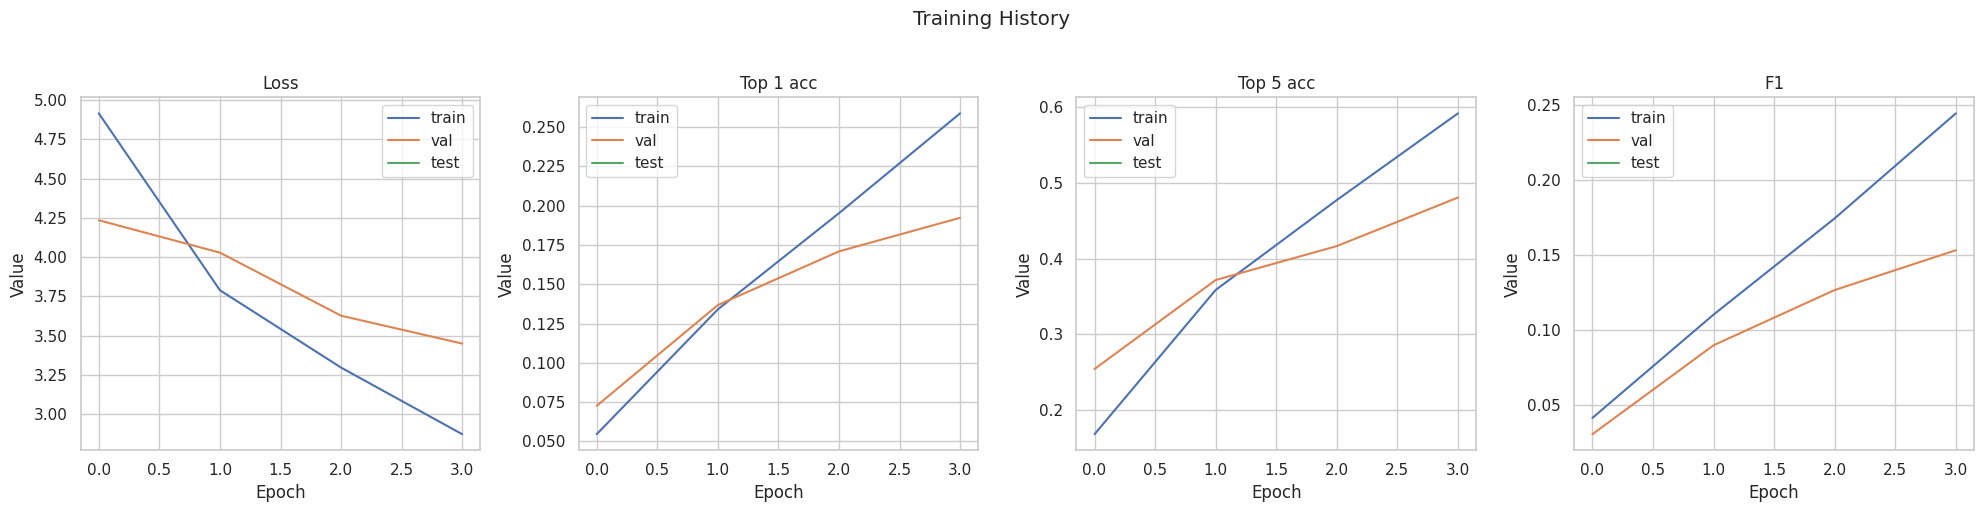

In [13]:
# Training configuration
config = {
    'epochs': 4,
    'mixed_precision': True,
    'max_norm': 1.0,
    'checkpoint_dir': 'checkpoints'
}

# Create trainer
trainer = Trainer(
    model=model,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    test_loader=test_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    metrics=metrics,
    config=config
)

# Start training
trainer.train()

# **Model Performance Evaluation**

This section focuses on evaluating and interpreting model performance through detailed comparison and visualization. By analyzing your implementation alongside state-of-the-art models, you will gain insights into their strengths, weaknesses, and unique characteristics.


### 1. **Model Benchmarking**
- Compare the performance of the following models on a standardized dataset:
  - **Custom R(2+1)D-9**: Trained from scratch.
  - **Pre-trained R(2+1)D-18**: Fine-tuned on Kinetics and UCF101.
  - **Pre-trained Swin3D-B**: Fine-tuned on Kinetics and UCF101.

### 2. **Feature Space Analysis**
- **Feature Extraction**: Analyze the feature representations learned by each model.
- **Visualization**: Use **t-SNE** to visualize the extracted features and identify patterns.
- **Clustering Evaluation**: Compare the quality of feature clustering across models to assess their ability to capture meaningful structures.


In [25]:
# Load pre-trained models
def load_models(device='cuda:0'):
    """Load models with their names and descriptions."""
    # Create custom R(2+1)D-10 model (uncompiled initially)
    r2plus1d_10_model = create_r2plus1d_10(num_classes=101)

    state_dict_custom = torch.load("checkpoints/latest.pt", map_location=device)["model"]
    # Remove "_orig_mod." prefix from keys if present, for compatibility with uncompiled model
    new_state_dict_custom = {}
    for k, v in state_dict_custom.items():
        if k.startswith('_orig_mod.'):
            new_state_dict_custom[k[len('_orig_mod.'):]] = v
        else:
            new_state_dict_custom[k] = v
    r2plus1d_10_model.load_state_dict(new_state_dict_custom)

    # Load torchvision's r2plus1d_18 and swin3d_b directly (these are full models, not just state_dicts)
    r2plus1d_18_tv = torch.load("r2plus1d_18_DEFAULT_finetuned_10_epochs.pth", map_location=device, weights_only=False)
    swin3d_b_tv = torch.load("swin3d_b_KINETICS400_IMAGENET22K_V1_finetuned_10_epochs.pth", map_location=device, weights_only=False)

    return {
        "r2plus1d_10": {
            "model": r2plus1d_10_model.to(device),
            "name": "R(2+1)D-10 (Custom)",
            "info": "Custom model trained from scratch on UCF101"
        },
        "r2plus1d_18": {
            "model": r2plus1d_18_tv.to(device),
            "name": "R(2+1)D-18 (Pretrained)",
            "info": "Torchvision R(2+1)D-18, Kinetics pretrained + UCF101 fine-tuned"
        },
        "swin3d_b": {
            "model": swin3d_b_tv.to(device),
            "name": "Swin3D-B (Pretrained)",
            "info": "Torchvision Swin3D-B, Kinetics pretrained + UCF101 fine-tuned"
        }
    }

# Remove the classification head to extract features
def remove_head(model):
    """Replace the classification head for Identity to create a feature extractor"""
    # Handle custom R2Plus1DResNet
    if isinstance(model, R2Plus1DResNet):
        model.head = nn.Identity()
    # Handle torchvision r2plus1d_18
    elif hasattr(model, 'fc'):
        model.fc = nn.Identity()
    # Handle torchvision swin3d_b
    elif hasattr(model, 'head') and isinstance(model.head, nn.Linear):
        model.head = nn.Identity()
    return model

# Extract features from a dataset
def extract_features(model, data_loader, device):
    """Extract features from all samples in the dataset."""
    # TODO: Prepare model for feature extraction
    model = remove_head(model) # Remove head on the original model
    model = torch.compile(model) # Compile the feature extractor
    model.eval() # Set to evaluation mode

    features, labels = [], []

    with torch.no_grad():
        for clips, targets in tqdm(data_loader, desc="Extracting features", leave=False):
            # TODO: Move data to device and extract features
            clips = clips.to(device)
            targets = targets.to(device)

            outputs = model(clips) # Extract features
            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())

    # TODO: Stack features and concatenate labels
    return np.vstack(features), np.concatenate(labels)

def visualize_features(features_list, labels, model_names):
    """Plot feature spaces using t-SNE for comparison."""
    plt.figure(figsize=(15, 5))

    # TODO: Create subplot for each model's features
    for i, (features, name) in enumerate(zip(features_list, model_names)):
        # TODO: Apply t-SNE dimensionality reduction
        embedded = TSNE(n_components=2, random_state=42).fit_transform(features)

        # TODO: Create scatter plot of embedded features
        plt.subplot(1, len(features_list), i + 1)
        plt.scatter(
            embedded[:, 0],
            embedded[:, 1],
            c=labels,
            cmap='nipy_spectral',
            alpha=0.7
        )
        plt.title(name)
        ax.set_xlabel('t-SNE component 1') # Add x-axis label
        ax.set_ylabel('t-SNE component 2') # Add y-axis label
        # plt.axis('off')

    # TODO: Add final plot touches
    plt.suptitle('t-SNE Visualization of Video Features', y=1.02) # Adjust suptitle position
    plt.tight_layout()
    plt.show()

# Compare models and visualize their feature spaces
def compare_models(data_loader, device='cuda:0'):
    """Compare different models by visualizing their feature spaces."""
    # TODO: Load all models
    models = load_models(device)
    features_list = []

    # Save original compiled model from trainer
    original_trainer_model = trainer.model

    # TODO: Evaluate each model and extract features
    for config in models.values():
        print(f"\nEvaluating: {config['name']}")
        print(f"Description: {config['info']}")

        # Get the uncompiled model
        current_model_plain = config['model']
        # Compile the current model before assigning it to the trainer's model
        trainer.model = torch.compile(current_model_plain) # Assign compiled version to trainer
        trainer.model.eval() # Set to evaluation mode for the trainer's test method

        # TODO: Print model statistics and test results
        trainer.print_params(trainable=False)
        print(" ".join(f"{key}={value:.4f}" for key, value in trainer.test().items()))

        # TODO: Extract and store features
        # Pass the original uncompiled model to extract_features as it handles removing the head and compiling internally
        features, labels = extract_features(current_model_plain, data_loader, device)
        features_list.append(features)

    # Restore original trainer model
    trainer.model = original_trainer_model

    # TODO: Visualize feature spaces for all models
    visualize_features(
        features_list,
        labels,
        [config['name'] for config in models.values()]
    )

In [26]:
# Run comparison on test set
compare_models(test_dataloader)


Evaluating: R(2+1)D-10 (Custom)
Description: Custom model trained from scratch on UCF101
Total parameters: 14.45M


loss=3.3364 top_1_acc=0.2080 top_5_acc=0.4860 f1=0.1780



Evaluating: R(2+1)D-18 (Pretrained)
Description: Torchvision R(2+1)D-18, Kinetics pretrained + UCF101 fine-tuned
Total parameters: 31.46M


AttributeError: 'CatchErrorsWrapper' object has no attribute '_torchdynamo_orig_backend'

### TODO: Comment your observations about the clusters

###### 3. **Error Analysis**
- **Misclassification Insights**: Identify and visualize misclassified video clips across models.
- **Pattern Recognition**: Group common error patterns and analyze recurring issues.
- **Model Limitations**: Discuss the limitations of each model based on identified errors.


In [ ]:
def find_mistakes(model: nn.Module, data_loader: DataLoader, device: str, num_examples: int = 6) -> Dict:
    """Find examples where the model made mistakes in its predictions."""
    # TODO: Prepare model for evaluation
    model = model.to(device)
    model.eval()

    predictions = []
    actual_labels = []
    video_clips = []

    # TODO: Collect model predictions
    with torch.no_grad():
        for videos, labels in tqdm(data_loader, desc="Finding mistakes", leave=False):
            # Move data to device
            videos = videos.to(device)
            labels = labels.to(device)

            # TODO: Get model predictions
            outputs = model(videos)
            batch_predictions = torch.argmax(outputs, dim=1)

            # TODO: Store results (move to CPU for numpy conversion)
            predictions.extend(batch_predictions.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())
            video_clips.extend(videos.cpu().numpy())

    # TODO: Find prediction mistakes
    predictions = np.array(predictions)
    actual_labels = np.array(actual_labels)
    video_clips = np.array(video_clips)

    mistakes = (predictions != actual_labels)  # Compare predictions with actual labels
    mistake_locations = np.where(mistakes)[0]  # Get indices where mistakes were made

    # TODO: Select random subset of mistakes
    chosen_examples = np.random.choice(
        mistake_locations,
        size=min(num_examples, len(mistake_locations)),
        replace=False
    )

    # Return mistake examples
    return {
        'correct_labels': actual_labels[chosen_examples],
        'model_predictions': predictions[chosen_examples],
        'video_clips': video_clips[chosen_examples]
    }

def show_mistake_videos(video_clips: np.ndarray,
                       correct_labels: np.ndarray,
                       model_predictions: np.ndarray,
                       activity_names: List[str],
                       model_name: str):
    """Display videos where model made mistakes with labels."""
    print("-" * 50)
    videos_to_show = {}

    # TODO: Prepare each video for display
    for i in range(len(video_clips)):
        # Get activity names
        correct_activity = activity_names[correct_labels[i]]
        predicted_activity = activity_names[model_predictions[i]]

        # Create informative title
        title = f"Example {i+1}\nCorrect: {correct_activity}\nPredicted: {predicted_activity}"

        # TODO: Prepare video for display
        video = video_clips[i]
        # Normalize to [0,1]
        video = (video - video.min()) / (video.max() - video.min())
        # Convert to uint8
        video = (video * 255).astype(np.uint8)
        # Rearrange dimensions
        video = rearrange(video, "c t h w -> t h w c")

        videos_to_show[title] = video

    # TODO: Display videos in grid
    mp.show_videos(
        videos_to_show,
        width=400,
        height=300,
        fps=4,
        columns=3,
        border=True
    )

def analyze_model_mistakes(test_loader: DataLoader, device: str = 'cuda:0'):
    """Analyze mistakes made by different models."""
    # TODO: Load models to analyze
    models_config = load_models(device)

    # TODO: Analyze each model's mistakes
    for model_id, config in models_config.items():
        print(f"\nAnalyzing mistakes for {config['name']}")

        # TODO: Find and visualize mistakes
        mistakes = find_mistakes(config['model'], test_loader, device)

        if mistakes is not None:
            show_mistake_videos(
                mistakes['video_clips'],
                mistakes['correct_labels'],
                mistakes['model_predictions'],
                test_loader.dataset.activities,
                config['name']
            )

        print("-" * 100)

In [ ]:
analyze_model_mistakes(test_dataloader)

### TODO: Comment your observations about the mistakes

### **Optional Task**
- **Fine-Tuning**: Fine-tune a pretrained video model on **UCF101**.
- **Comparison**: Evaluate and compare its performance against the base implementation.


You can select SlowFast or any model presented in torchvision
```python
model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r50', pretrained=True)
```
or

[Torchvision Pretrained Models for Video Classification](https://pytorch.org/vision/main/models.html#video-classification)


In [ ]:
# Your code